In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 84.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=bda45bd56650c6c8251b4381d2c122bb8029754513a6c25a80950052ab4edf21
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [2]:
import chess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from typing import List, Tuple
import torch.optim as optim
import time
from tqdm import tqdm

seed = 123456
np.random.seed(seed=seed)

# Разработка модели


In [3]:
class ChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)

        self._validate_data()
        self.piece_to_idx = {
            "P": 0,
            "N": 1,
            "B": 2,
            "R": 3,
            "Q": 4,
            "K": 5,
            "p": 6,
            "n": 7,
            "b": 8,
            "r": 9,
            "q": 10,
            "k": 11,
        }

    def _validate_data(self):
        valid_indices = []
        for idx, row in self.df.iterrows():
            try:
                board = chess.Board(row["fen"])
                move = chess.Move.from_uci(row["move"])
                if move in board.legal_moves:
                    valid_indices.append(idx)
            except:
                continue

        self.df = self.df.loc[valid_indices].reset_index(drop=True)
        print(f"Загружено {len(self.df)} валидных позиций")

    def _board_to_tensor(self, fen: str) -> torch.Tensor:
        board = chess.Board(fen)
        tensor = torch.zeros(20, 8, 8, dtype=torch.float32)

        # Фигуры (плоскости 0-11)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                row, col = square // 8, square % 8
                piece_idx = self.piece_to_idx[piece.symbol()]
                tensor[piece_idx, row, col] = 1.0

        # Чей ход (плоскость 12)
        tensor[12] = 1.0 if board.turn else 0.0

        # Рокировки (плоскости 13-16)
        castling_rights = [
            board.has_kingside_castling_rights(chess.WHITE),
            board.has_queenside_castling_rights(chess.WHITE),
            board.has_kingside_castling_rights(chess.BLACK),
            board.has_queenside_castling_rights(chess.BLACK),
        ]
        for i, has_right in enumerate(castling_rights):
            if has_right:
                tensor[13 + i] = 1.0

        # Взятие на проходе (плоскость 17)
        if board.ep_square is not None:
            row, col = board.ep_square // 8, board.ep_square % 8
            tensor[17, row, col] = 1.0

        # Счетчик полуходов (плоскость 18)
        tensor[18] = board.halfmove_clock / 50.0

        # Номер хода (плоскость 19)
        tensor[19] = board.fullmove_number / 500.0

        return tensor

    def _move_to_dual_labels(self, move_uci: str, fen: str) -> tuple:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        from_square = move.from_square

        # Для to_square учитываем превращения
        # ДИАПАЗОН ДОЛЖЕН БЫТЬ 0-68 (69 классов)
        # print(move.promotion)
        if move.promotion:
            # Кодируем превращения: 64-68
            to_square = 64 + (move.promotion - 1)  # 64, 65, 66, 67, 68
        else:
            to_square = move.to_square  # 0-63

        # Проверяем, что to_square в правильном диапазоне
        if to_square >= 69:
            raise ValueError(f"Некорректный to_square: {to_square} для хода {move_uci}")

        return from_square, to_square

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row["fen"]
        move = row["move"]

        board_tensor = self._board_to_tensor(fen)
        from_label, to_label = self._move_to_dual_labels(move, fen)

        return board_tensor, from_label, to_label

In [4]:
class ChessDataSplitter:
    def __init__(
        self,
        csv_file,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        random_state=42,
    ):
        print(train_ratio, val_ratio, test_ratio)
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
            "Сумма долей должна быть равна 1"
        )

        self.csv_file = csv_file
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        # Загружаем полный dataset
        self.full_dataset = ChessDataset(csv_file)

    def split_data(self):
        """Разбивает данные на train/val/test"""
        # Получаем индексы
        n_total = len(self.full_dataset)
        indices = list(range(n_total))

        # Первое разбиение: отделяем test
        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=self.test_ratio,
            random_state=self.random_state,
            shuffle=True,
        )

        # Второе разбиение: разделяем train и val
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.val_ratio / (self.train_ratio + self.val_ratio),
            random_state=self.random_state,
            shuffle=True,
        )

        # Создаем Subset datasets
        train_dataset = Subset(self.full_dataset, train_idx)
        val_dataset = Subset(self.full_dataset, val_idx)
        test_dataset = Subset(self.full_dataset, test_idx)

        print(f"Разбиение завершено:")
        print(
            f"Train: {len(train_dataset)} samples ({len(train_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Val: {len(val_dataset)} samples ({len(val_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Test: {len(test_dataset)} samples ({len(test_dataset) / n_total * 100:.1f}%)"
        )

        return train_dataset, val_dataset, test_dataset

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)


class ChessResNetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial convolution
        self.conv_input = nn.Conv2d(20, 256, 3, padding=1)
        self.bn_input = nn.BatchNorm2d(256)

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(5)])

        # Attention mechanism
        self.attention_conv = nn.Conv2d(256, 1, 1)

        # Policy head
        self.policy_conv = nn.Conv2d(256, 69, 1)  # 64 moves + 5 promotions

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.bn_input(self.conv_input(x)))
        x = self.res_blocks(x)

        # Spatial attention
        attention_weights = F.softmax(
            self.attention_conv(x).view(x.size(0), -1), dim=1
        ).view(x.size(0), 1, 8, 8)

        # Apply attention
        x_attended = x * attention_weights

        # Policy head
        policy = self.policy_conv(x_attended)
        policy = policy.view(policy.size(0), 69, 64)  # [batch, move_types, squares]

        return policy

In [6]:
class ChessTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        device="cpu",
        lr=0.01,
        weight_decay=0.1,
        step_size=5,
        gamma=0.8
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.lr = lr
        self.weight_decay = weight_decay
        self.step_size = step_size
        self.gamma = gamma

        # Функция потерь для policy head
        self.criterion = nn.CrossEntropyLoss()

        # Оптимизатор
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=self.lr,  # Уменьшил learning rate для стабильности
            weight_decay=self.weight_decay,
        )

        # Планировщик learning rate
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=self.step_size, gamma=self.gamma
        )

        # История обучения
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
            "learning_rate": [],
        }

    def _policy_to_move_labels(self, policy_output, from_targets, to_targets):
        """
        Преобразует policy output [batch, 69, 64] в метки ходов
        и сравнивает с целевыми метками
        """
        batch_size = policy_output.size(0)

        # Создаем целевые метки в формате [batch, 4672]
        target_labels = []
        for i in range(batch_size):
            from_sq = from_targets[i].item()
            to_sq = to_targets[i].item()

            # Определяем тип хода
            if to_sq >= 64:
                # Ход с превращением
                promotion_type = to_sq - 64  # 0-3
                move_label = from_sq * 69 + (64 + promotion_type)
            else:
                # Обычный ход
                move_label = from_sq * 69 + to_sq

            target_labels.append(move_label)

        return torch.tensor(target_labels, device=self.device)

    def _decode_policy_prediction(self, policy_output):
        """
        Декодирует policy output в предсказанные from_square и to_square
        """
        batch_size = policy_output.size(0)

        # Reshape to [batch, 4672]
        policy_flat = policy_output.view(batch_size, -1)

        # Находим наиболее вероятный ход
        move_preds = torch.argmax(policy_flat, dim=1)

        from_preds = move_preds // 73
        move_type = move_preds % 73

        # Определяем to_square и promotion
        to_preds = []
        promo_preds = []
        for move_type_val in move_type:
            if move_type_val >= 64:
                # Ход с превращением
                to_preds.append(move_type_val - 64)  # to_square для превращений
                promo_preds.append(move_type_val - 63)  # 1=queen, 2=rook, etc.
            else:
                # Обычный ход
                to_preds.append(move_type_val)
                promo_preds.append(0)

        return (from_preds.cpu(), torch.tensor(to_preds), torch.tensor(promo_preds))

    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        train_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, (boards, from_targets, to_targets) in enumerate(train_bar):
            # Перемещаем данные на device
            boards = boards.to(self.device)
            from_targets = from_targets.to(self.device)
            to_targets = to_targets.to(self.device)

            # Обнуляем градиенты
            self.optimizer.zero_grad()

            # Прямой проход
            policy_output = self.model(boards)  # [batch, 69, 64]

            # Преобразуем policy output в формат для loss
            policy_flat = policy_output.view(policy_output.size(0), -1)  # [batch, 4672]

            # Создаем целевые метки
            target_labels = self._policy_to_move_labels(
                policy_output, from_targets, to_targets
            )

            # Вычисляем потери
            loss = self.criterion(policy_flat, target_labels)

            # Обратный проход
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Шаг оптимизатора
            self.optimizer.step()

            # Статистика
            total_loss += loss.item()
            batch_size = boards.size(0)
            total_samples += batch_size

            # Точность
            preds = torch.argmax(policy_flat, dim=1)
            correct = (preds == target_labels).sum().item()
            total_correct += correct

            # Обновляем progress bar
            train_bar.set_postfix(
                {
                    "Loss": f"{loss.item():.4f}",
                    "Accuracy": f"{correct / batch_size:.3f}",
                }
            )

        # Вычисляем средние метрики за эпоху
        avg_loss = total_loss / len(self.train_loader)
        accuracy = total_correct / total_samples

        return avg_loss, accuracy

    def validate(self):
        """Валидация модели"""
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.val_loader, desc="Validation"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Прямой проход
                policy_output = self.model(boards)
                policy_flat = policy_output.view(policy_output.size(0), -1)

                # Целевые метки
                target_labels = self._policy_to_move_labels(
                    policy_output, from_targets, to_targets
                )

                # Потери
                loss = self.criterion(policy_flat, target_labels)

                total_loss += loss.item()
                batch_size = boards.size(0)
                total_samples += batch_size

                # Точность
                preds = torch.argmax(policy_flat, dim=1)
                correct = (preds == target_labels).sum().item()
                total_correct += correct

        avg_loss = total_loss / len(self.val_loader)
        accuracy = total_correct / total_samples

        return avg_loss, accuracy

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Полный цикл обучения"""
        best_val_loss = float("inf")
        patience_counter = 0

        print("Начало обучения ResNet модели...")
        print(f"Используется устройство: {self.device}")
        print(f"Размер тренировочного набора: {len(self.train_loader.dataset)}")
        print(f"Размер валидационного набора: {len(self.val_loader.dataset)}")
        print(f"Количество классов: 4672")

        for epoch in range(num_epochs):
            print(f"\nЭпоха {epoch + 1}/{num_epochs}")
            print("-" * 50)

            # Обучение
            train_loss, train_acc = self.train_epoch()

            # Валидация
            val_loss, val_acc = self.validate()

            # Обновление learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]["lr"]

            # Сохраняем историю
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_accuracy"].append(train_acc)
            self.history["val_accuracy"].append(val_acc)
            self.history["learning_rate"].append(current_lr)

            # Выводим результаты
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Сохранение лучшей модели
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model("best_chess_resnet_model.pth")
                print("Сохранена лучшая модель!")
            else:
                patience_counter += 1
                print(
                    f"Early stopping: {patience_counter}/{early_stopping_patience}"
                )

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print("Ранняя остановка!")
                break

        print("\nОбучение завершено!")
        self.plot_training_history()

    def evaluate(self):
        """Финальная оценка на тестовом наборе"""
        print("\nОценка на тестовом наборе...")
        self.model.eval()

        total_correct = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.test_loader, desc="Testing"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.cpu()
                to_targets = to_targets.cpu()

                # Прямой проход
                policy_output = self.model(boards)

                # Декодируем предсказания
                from_preds, to_preds, promo_preds = self._decode_policy_prediction(
                    policy_output
                )

                # Подсчет правильных предсказаний
                batch_size = boards.size(0)
                total_samples += batch_size

                # Полная точность хода
                policy_flat = policy_output.view(policy_output.size(0), -1)
                target_labels = self._policy_to_move_labels(
                    policy_output,
                    from_targets.to(self.device),
                    to_targets.to(self.device),
                )
                preds = torch.argmax(policy_flat, dim=1)
                correct = (preds == target_labels).sum().item()
                total_correct += correct

                # Точность для from-square
                from_correct = (from_preds == from_targets).sum().item()
                total_from_correct += from_correct

                # Точность для to-square (учитывая превращения)
                to_correct = (to_preds == to_targets).sum().item()
                total_to_correct += to_correct

        full_acc = total_correct / total_samples
        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples

        print(f"\nРезультаты на тестовом наборе:")
        print(f"Full Move Accuracy: {full_acc:.4f}")
        print(f"From-square Accuracy: {from_acc:.4f}")
        print(f"To-square Accuracy: {to_acc:.4f}")

        return full_acc, from_acc, to_acc

    def save_model(self, path):
        """Сохранение модели"""
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "history": self.history,
            },
            path,
        )

    def load_model(self, path):
        """Загрузка модели"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.history = checkpoint["history"]

    def plot_training_history(self):
        """Визуализация истории обучения"""
        import matplotlib.pyplot as plt

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Потери
        ax1.plot(self.history["train_loss"], label="Train Loss")
        ax1.plot(self.history["val_loss"], label="Val Loss")
        ax1.set_title("Потери")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        # Точность
        ax2.plot(self.history["train_accuracy"], label="Train Accuracy")
        ax2.plot(self.history["val_accuracy"], label="Val Accuracy")
        ax2.set_title("Точность")
        ax2.set_xlabel("Эпоха")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        # Learning rate
        ax3.plot(self.history["learning_rate"])
        ax3.set_title("Learning Rate")
        ax3.set_xlabel("Эпоха")
        ax3.set_ylabel("LR")
        ax3.grid(True)

        # Соотношение потерь
        ax4.plot(self.history["train_loss"], label="Train Loss", alpha=0.7)
        ax4.plot(self.history["val_loss"], label="Val Loss", alpha=0.7)
        ax4.set_title("Потери (логарифмическая шкала)")
        ax4.set_xlabel("Эпоха")
        ax4.set_ylabel("Loss")
        ax4.set_yscale("log")
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig("training_history_resnet.png", dpi=300, bbox_inches="tight")
        plt.show()

    def predict_move(self, fen):
        """Предсказание хода для одной позиции"""
        self.model.eval()

        # Преобразование FEN в tensor
        board_tensor = self._fen_to_tensor(fen).unsqueeze(0).to(self.device)

        with torch.no_grad():
            policy_output = self.model(board_tensor)  # [1, 73, 64]
            from_pred, to_pred, promotion = self._decode_policy_prediction(
                policy_output
            )

        return from_pred[0].item(), to_pred[0].item(), promotion[0].item()

In [16]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используется устройство: {device}")

    # Загрузка данных
    print("Загрузка данных...")
    splitter = ChessDataSplitter(
        test_ratio=0.01,
        val_ratio=0.2 * (1 - 0.01),
        train_ratio=0.8 * (1 - 0.01),
        csv_file="/kaggle/input/fens-training-set/fens_training_set.csv",
    )
    train_dataset, val_dataset, test_dataset = splitter.split_data()
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Модель
    print("Инициализация модели...")
    model = ChessResNetWithAttention()

    # Тренер
    trainer = ChessTrainer(model, train_loader, val_loader, test_loader, device, lr=0.01, weight_decay=0.2, step_size=2, gamma=0.1)

    # Обучение
    trainer.train(num_epochs=20, early_stopping_patience=10)

    # Валидация
    trainer.validate()

    # # Сохранение финальной модели
    # trainer.save_model("final_chess_model.pth")
    # print("Модель сохранена!")

Используется устройство: cuda
Загрузка данных...
0.792 0.198 0.01
Загружено 268549 валидных позиций
Разбиение завершено:
Train: 212690 samples (79.2%)
Val: 53173 samples (19.8%)
Test: 2686 samples (1.0%)
Инициализация модели...
Начало обучения ResNet модели...
Используется устройство: cuda
Размер тренировочного набора: 212690
Размер валидационного набора: 53173
Количество классов: 4672

Эпоха 1/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.68it/s]


Train Loss: 7.0508 | Val Loss: 6.5638
Train Accuracy: 0.0338 | Val Accuracy: 0.0464
Learning Rate: 0.010000
Сохранена лучшая модель!

Эпоха 2/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.23it/s]


Train Loss: 5.9973 | Val Loss: 5.8328
Train Accuracy: 0.0847 | Val Accuracy: 0.0990
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 3/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.17it/s]


Train Loss: 4.7132 | Val Loss: 4.5353
Train Accuracy: 0.1852 | Val Accuracy: 0.1873
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 4/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.94it/s]


Train Loss: 4.2704 | Val Loss: 4.2905
Train Accuracy: 0.2178 | Val Accuracy: 0.2098
Learning Rate: 0.000100
Сохранена лучшая модель!

Эпоха 5/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.03it/s]


Train Loss: 3.8060 | Val Loss: 3.9709
Train Accuracy: 0.2695 | Val Accuracy: 0.2461
Learning Rate: 0.000100
Сохранена лучшая модель!

Эпоха 6/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.94it/s]


Train Loss: 3.6879 | Val Loss: 3.9162
Train Accuracy: 0.2814 | Val Accuracy: 0.2490
Learning Rate: 0.000010
Сохранена лучшая модель!

Эпоха 7/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.30it/s]


Train Loss: 3.5991 | Val Loss: 3.9085
Train Accuracy: 0.2936 | Val Accuracy: 0.2526
Learning Rate: 0.000010
Сохранена лучшая модель!

Эпоха 8/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.13it/s]


Train Loss: 3.5851 | Val Loss: 3.9052
Train Accuracy: 0.2958 | Val Accuracy: 0.2523
Learning Rate: 0.000001
Сохранена лучшая модель!

Эпоха 9/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.47it/s]


Train Loss: 3.5746 | Val Loss: 3.9023
Train Accuracy: 0.2976 | Val Accuracy: 0.2530
Learning Rate: 0.000001
Сохранена лучшая модель!

Эпоха 10/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.00it/s]


Train Loss: 3.5734 | Val Loss: 3.9008
Train Accuracy: 0.2974 | Val Accuracy: 0.2526
Learning Rate: 0.000000
Сохранена лучшая модель!

Эпоха 11/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.83it/s]


Train Loss: 3.5729 | Val Loss: 3.9052
Train Accuracy: 0.2981 | Val Accuracy: 0.2526
Learning Rate: 0.000000
Early stopping: 1/10

Эпоха 12/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.81it/s]


Train Loss: 3.5716 | Val Loss: 3.9048
Train Accuracy: 0.2979 | Val Accuracy: 0.2524
Learning Rate: 0.000000
Early stopping: 2/10

Эпоха 13/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.99it/s]


Train Loss: 3.5715 | Val Loss: 3.9002
Train Accuracy: 0.2978 | Val Accuracy: 0.2532
Learning Rate: 0.000000
Сохранена лучшая модель!

Эпоха 14/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.85it/s]


Train Loss: 3.5731 | Val Loss: 3.9057
Train Accuracy: 0.2979 | Val Accuracy: 0.2523
Learning Rate: 0.000000
Early stopping: 1/10

Эпоха 15/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.02it/s]


Train Loss: 3.5717 | Val Loss: 3.9013
Train Accuracy: 0.2978 | Val Accuracy: 0.2527
Learning Rate: 0.000000
Early stopping: 2/10

Эпоха 16/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.04it/s]


Train Loss: 3.5715 | Val Loss: 3.9026
Train Accuracy: 0.2978 | Val Accuracy: 0.2526
Learning Rate: 0.000000
Early stopping: 3/10

Эпоха 17/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.01it/s]


Train Loss: 3.5718 | Val Loss: 3.9083
Train Accuracy: 0.2977 | Val Accuracy: 0.2525
Learning Rate: 0.000000
Early stopping: 4/10

Эпоха 18/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 58.24it/s]


Train Loss: 3.5716 | Val Loss: 3.9008
Train Accuracy: 0.2979 | Val Accuracy: 0.2528
Learning Rate: 0.000000
Early stopping: 5/10

Эпоха 19/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.62it/s]


Train Loss: 3.5720 | Val Loss: 3.9068
Train Accuracy: 0.2977 | Val Accuracy: 0.2523
Learning Rate: 0.000000
Early stopping: 6/10

Эпоха 20/20
--------------------------------------------------


Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.82it/s]


Train Loss: 3.5717 | Val Loss: 3.9038
Train Accuracy: 0.2977 | Val Accuracy: 0.2523
Learning Rate: 0.000000
Early stopping: 7/10

Обучение завершено!


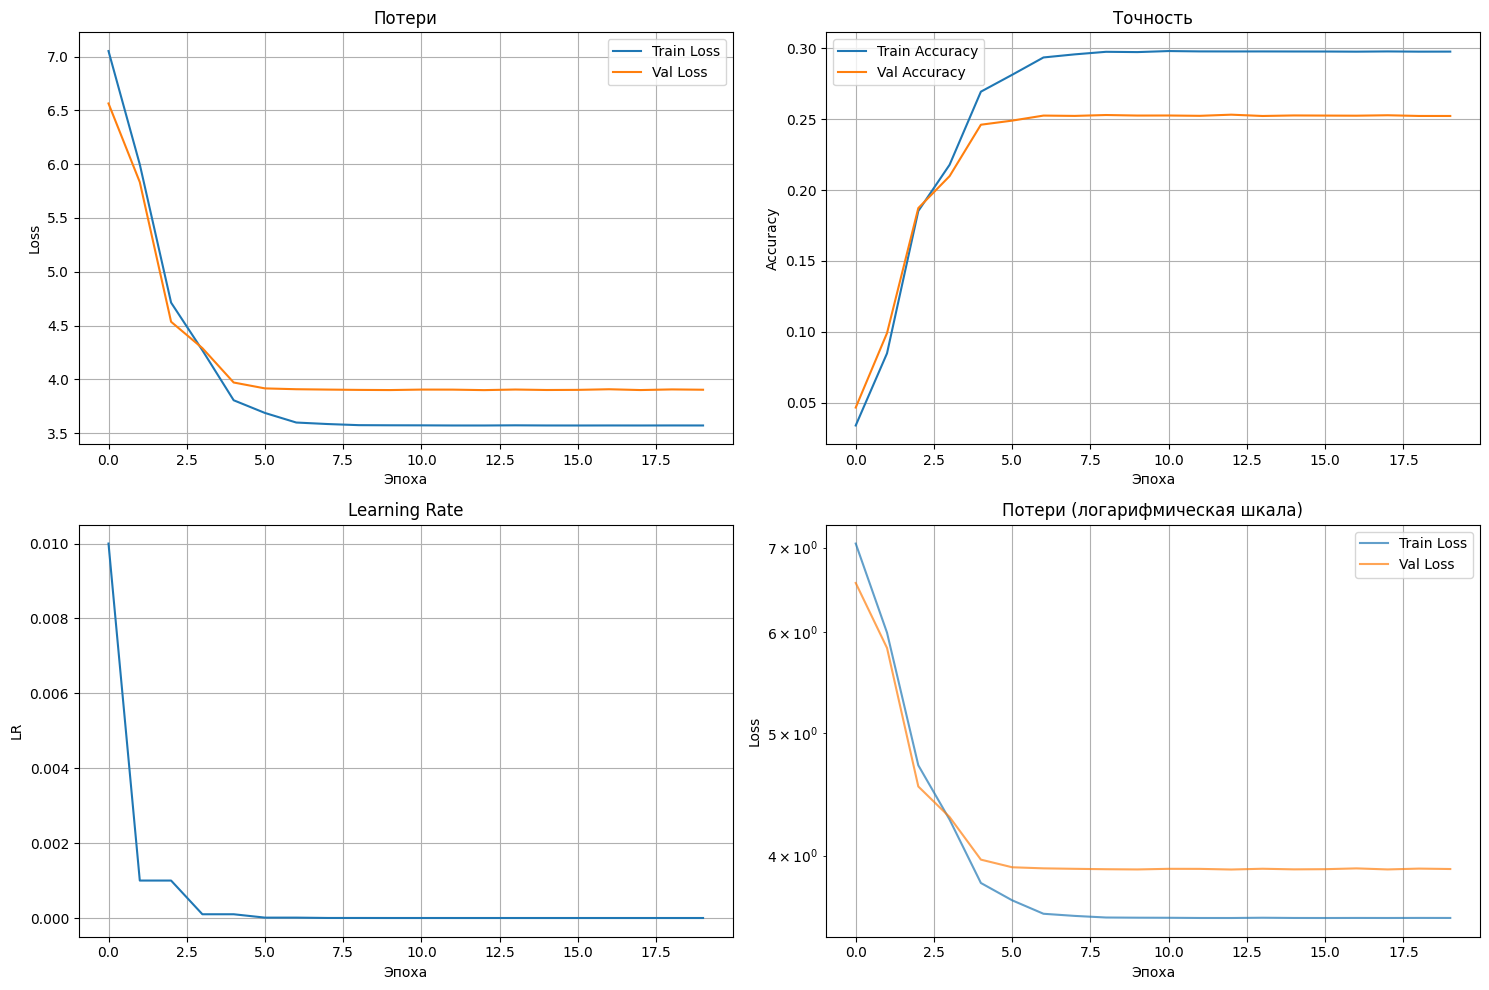

Validation: 100%|██████████| 1662/1662 [00:28<00:00, 57.38it/s]


In [17]:
if __name__ == "__main__":
    main()

In [18]:
import matplotlib.image as mpimg

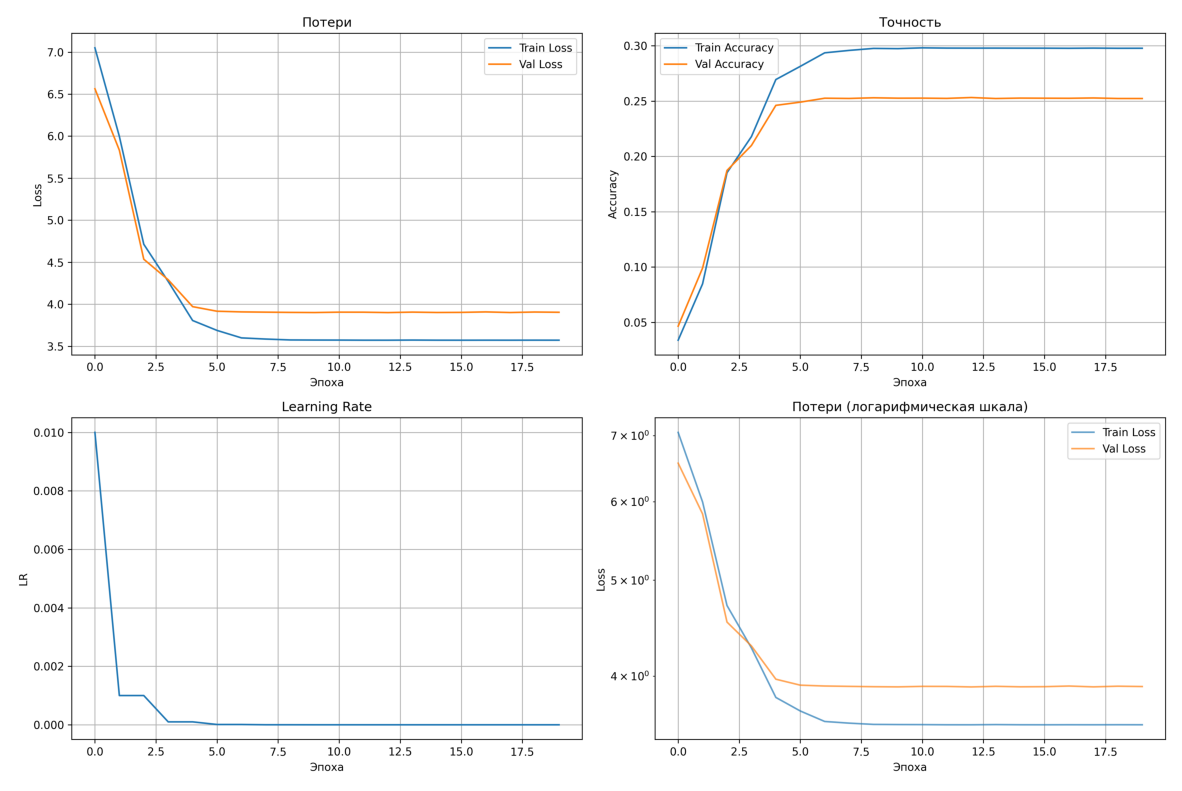

In [19]:
image_path = '/kaggle/working/training_history_resnet.png'
img = mpimg.imread(image_path)
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()